<a href="https://colab.research.google.com/github/jessecanada/MAPS/blob/master/MAPS_3_Phenotype_Discovery_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **MAPS Module 3 - Phenotype Discovery**
<br>
This notebook will guide you through generating cell galleries to help you discover the classes of phenotypes needed to train the final classification model.
<br>
Here, we will perform feature extraction using pre-trained VGG16 model.
<br> 


> Note: Verified to work with Keras-TensorFlow 2.4.1



# Import dataset

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir cells

In [ ]:
# import single cell images from Google Drive and unzip
# "-q",quiet mode; "-d", directory
!unzip -q -d /content/cells/ /content/drive/MyDrive/-your-image-directory.zip  

In [ ]:
# confirm how many cells are to be analyzed
!ls /content/cells/* | wc -l

4122


# Import packages 

In [ ]:
# deep learning libraries
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model

# data and file processing libraries
import numpy as np
import pandas as pd
import cv2
import os
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl

# manifold learning libraries
import umap
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering 
from sklearn import metrics

In [ ]:
# uncomment to check tensorflow version
#import tensorflow as tf
#print(f'tensorflow version: {tf.__version__}')

2.4.1


# Load pre-trained VGG-16 model and reconfigure


*   We only need the convolutional blocks
*   Use ImageNet weights

In [ ]:
# load pre-trained VGG16 model
# include_top=False loads only the convolutional modules
# otherwise, loading the fully connected layers forces
# you to use a fixed input size of(224x224)
model = VGG16(weights='imagenet', include_top=False)

In [ ]:
# summarize filters in each convolutional layer
for layer in model.layers:
  # check if convolutional layer
  if 'conv' not in layer.name:
    continue
  else:
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

block1_conv1 (3, 3, 3, 64)
block1_conv2 (3, 3, 64, 64)
block2_conv1 (3, 3, 64, 128)
block2_conv2 (3, 3, 128, 128)
block3_conv1 (3, 3, 128, 256)
block3_conv2 (3, 3, 256, 256)
block3_conv3 (3, 3, 256, 256)
block4_conv1 (3, 3, 256, 512)
block4_conv2 (3, 3, 512, 512)
block4_conv3 (3, 3, 512, 512)
block5_conv1 (3, 3, 512, 512)
block5_conv2 (3, 3, 512, 512)
block5_conv3 (3, 3, 512, 512)


In [ ]:
# reconfigure the model so that the output is an intermediate convolutional layer
layer_name = 'block3_pool'
layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output) # output featuremap from block4 pooling layer

# Extract features

### gather images, convert to tensors

In [ ]:
# convert images to numpy array with shape (samples, rows, cols, channels)
raw_file_list = glob.glob("/content/cells/*/*.jpg")
input_list = []
good_ims = []

for file_path in raw_file_list:
  cv2_im = cv2.imread(file_path, -1)
  # filter out junk
  if cv2_im.shape[0]<80 or cv2_im.shape[1]<80:
    continue
  # process the good stuff
  else:
    input_list.append(file_path) # file paths to good images
    # preprocess for VGG16
    img = image.load_img(file_path, target_size=(148, 148))
    x = image.img_to_array(img)
    x = preprocess_input(x)
    good_ims.append(x)

images = np.array(good_ims)

In [ ]:
# confirm that the resulting array is correct
# shape: (batch, w, h, ch)
images.shape

(1289, 148, 148, 3)

## feature extraction

In [ ]:
# output featuremap from the specified layer
print(f'Extracting features from {layer_name}...', '\n')
%time layer_features = layer_model.predict(images)
print('\n', f'Done! each ROI has shape {layer_features[0].shape}')

Extracting features from block3_pool... 

CPU times: user 3min 21s, sys: 2.95 s, total: 3min 24s
Wall time: 1min 44s

 Done! each ROI has shape (18, 18, 256)


# Visualizing the intermediate outputs of VGG16

## Feature map visualization


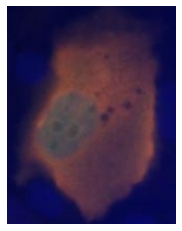

In [ ]:
# visualize a sample cell image

for idx, file_path in enumerate(input_list):
  if "file_name" in file_path: # replace "file_name" with your own
    sample = image.load_img(file_path)
    sample_idx = idx
plt.imshow(sample)
plt.axis('off')
plt.show(); plt.close()

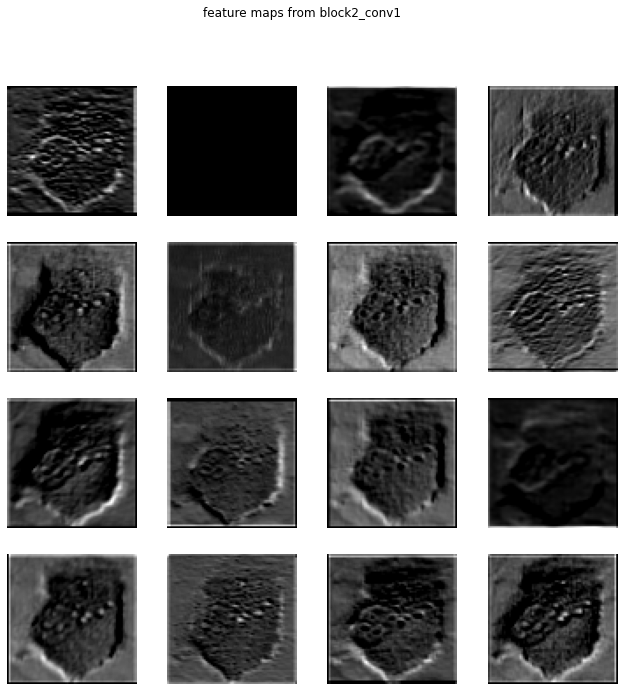

In [ ]:
# visualize the featuremap of a random image in 4x4 matplotlib figure
square = 4
sample_feats = layer_features[sample_idx]

idx = 1
fig = plt.figure(figsize=(11,11))
fig.suptitle(f'feature maps from {layer_name}', fontsize=12)
for _ in range(square):
  for _ in range(square):
      ax = plt.subplot(square, square, idx)
      plt.imshow(sample_feats[:,:,idx], cmap='gray')
      ax.set_axis_off()
      idx += 1

plt.show()

## Convnet filter visualization 
Adapted from [Keras blog](https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/visualizing_what_convnets_learn.ipynb).
<br>
Displays the visual patterns that convnet filters respond to.

In [ ]:
import keras.backend as K
from keras import metrics

In [ ]:
print(model.name)
print(layer_name)

vgg16
block2_conv1


In [ ]:
# Set up a model that returns the activation values for our target layer
layer = model.get_layer(name=layer_name)
feature_extractor = Model(inputs=model.inputs, outputs=layer.output)

Set up the gradient ascent process
The "loss" we will maximize is simply the mean of the activation of a specific filter in our target layer. To avoid border effects, we exclude border pixels.

In [ ]:
def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

Our gradient ascent function simply computes the gradients of the loss above with regard to the input image, and update the update image so as to move it towards a state that will activate the target filter more strongly.

In [ ]:
import tensorflow as tf

In [ ]:
@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img

##### Set up an end-to-end filter visualization loop

 

1.   Initialize a random image that is close to all gray (i.e. visually netural)
2.   Repeatedly apply the gradient ascent function defined above
3.   Convert the resulting input image back to a displayable form, by normalizing it,
center-cropping it, and restricting it to the [0, 255] range.


In [ ]:
def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, img_width, img_height, 3))
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25

def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 30
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img

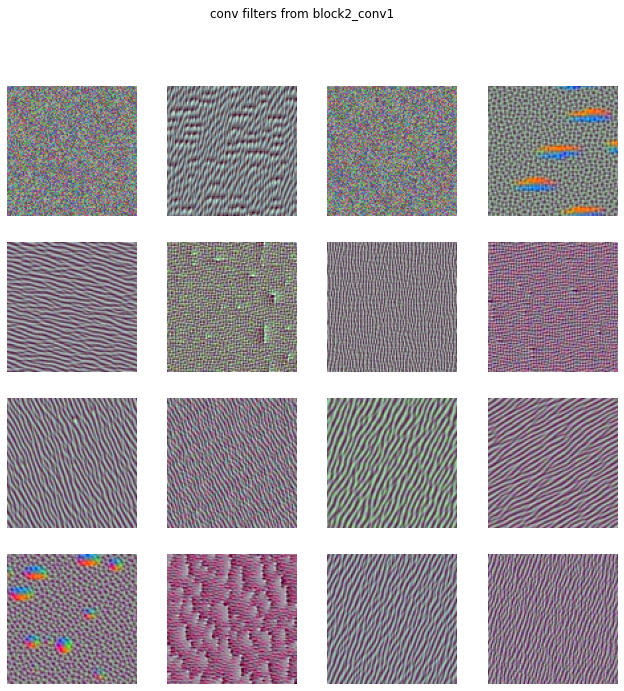

In [ ]:
img_width, img_height = (images[0].shape[:2])
idx = 1
square = 4
filter_idx = 0

fig = plt.figure(figsize=(11,11))
fig.suptitle(f'conv filters from {layer_name}')
for _ in range(square):
  for _ in range(square):
      ax = plt.subplot(square, square, idx)
      loss, filter_viz = visualize_filter(filter_idx)
      plt.imshow(filter_viz)
      ax.set_axis_off()
      idx += 1
      filter_idx += 1

plt.show(); plt.close()

#Generate cell gallery using manifold learning and clustering
UMAP and spectral clustering

*   [UMAP](https://umap-learn.readthedocs.io/) generates a 2-dimensional manifold of cellular phenotypes
*   spectral clustering groups cells with similar phenotypes



In [ ]:
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import random
def images_in_plot(img_path_list, x, y, num_2plot=70):
  ''' img_pth_list: a list of image file paths
      x, y: x, y vals of the scatterplot dot to overlaid img to
      num_2plot: number of images to insert into the plot DEFAULT:70
      ax: matplotlib axis object
      return: list of AnnotationBox objects
      '''
  num_images = len(img_path_list)
  ab_list = []
  for i in range(num_2plot):
    idx = int(random.random() * num_images)
    img2plot = cv2.imread(img_path_list[idx], -1) # openCV reads in BGR
    r = img2plot[:,:,2] # get red channel only for PTEN
    imbox = OffsetImage(r, zoom=0.35, cmap='gray')
    ab = AnnotationBbox(imbox, (x[idx], y[idx]), xycoords='data', frameon=False)
    ab_list.append(ab)
  return ab_list

In [ ]:
# check optimal number of clusters
def best_num_clusters(embedding):
  best = 0
  for n in range(2, 6, 1):
    spectral_model_nn = SpectralClustering(n_clusters=n, affinity='nearest_neighbors', n_neighbors=15) 
    labels_nn = spectral_model_nn.fit_predict(embedding)
    score = metrics.silhouette_score(embedding, labels_nn, metric='euclidean')
    print(f'num_clusters: {n}, Silhouette Coefficient={score:.3f}')
    if score > best:
      best = score
      n_clusters = n
      labels = labels_nn
  return n_clusters, labels

### UMAP

In [ ]:
# flatten feature maps
flat_feat_map = np.array([feat_map.flatten() for feat_map in layer_features])
# how many features per ROI?
flat_feat_map[0].shape

(82944,)

In [ ]:
# uncomment if you need ot save the extracted features for later
# np.savetxt("xxx.csv", flat_feat_map, delimiter=",") # replace 'xxx' with file name

First, perform PCA to reduce the number of dimensions in our feature space

In [ ]:
# tune 'n_components'
%time pca = PCA(n_components=500, svd_solver= 'auto').fit_transform(flat_feat_map)

CPU times: user 36.9 s, sys: 3.77 s, total: 40.7 s
Wall time: 22.5 s


Second, use UMAP to learn the manifold and embed the datapoints in 2D for visualization

In [ ]:
# try different Minkowski style metrics: "euclidean", "manhattan"
# "chebyshev", "minkowski"
reducer = umap.UMAP(n_neighbors=100,
                    min_dist=0.1,
                    metric="chebyshev",
                    random_state=42)

%time embedding = reducer.fit_transform(pca)

CPU times: user 9.22 s, sys: 123 ms, total: 9.34 s
Wall time: 9.14 s


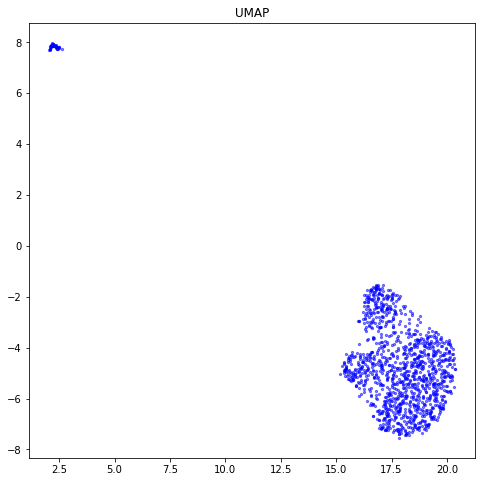

In [ ]:
x = embedding[:,0]
y = embedding[:,1]

fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.scatter(x, y, marker='o', c='b', alpha=0.5, s=5)
ax.set_title('UMAP')
mpl.rcParams['pdf.fonttype'] = 42
plt.savefig("VGG16_UMAP.pdf", format='pdf', dpi=100, bbox_inches='tight')
plt.show(); plt.close()

### Clustering

use kmeans clustering to remove the smaller cluster

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(embedding)

In [ ]:
print(f'label_0: {len(kmeans.labels_[kmeans.labels_==0])}')
print(f'label_1: {len(kmeans.labels_[kmeans.labels_==1])}')

label_0: 1246
label_1: 43


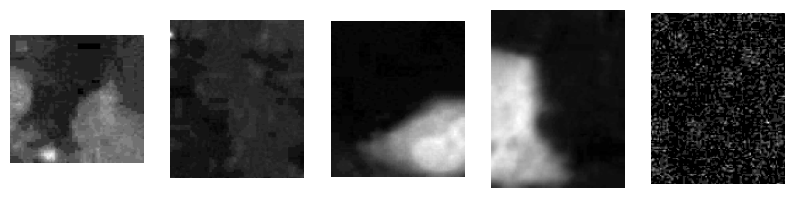

In [ ]:
# grab images with label==1
cluster_1_ims = []
counter = 0
for idx, label in enumerate(kmeans.labels_):
  if label == 1:
    counter+=1
    if counter < 6:
      cluster_1_ims.append(input_list[idx])

# show those images
fig, axes = plt.subplots(1,5, figsize=(10,5), dpi=100)
for ax, im_path in zip(axes.ravel(), cluster_1_ims):
  img = cv2.imread(im_path, -1)
  r = img[:,:,2]
  ax.imshow(r, cmap='gray')
  ax.set_axis_off()

plt.show()

In [ ]:
# extract clusters
from itertools import compress
extracted_cluster = np.array(list(compress(embedding, kmeans.labels_==0)))
fltrd_file_list = list(compress(input_list, kmeans.labels_==0))
print(f'extracted cluster has {len(extracted_cluster)} ROIs')

extracted cluster has 1245 ROIs


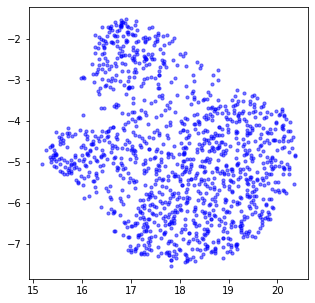

In [ ]:
x = extracted_cluster[:,0]
y = extracted_cluster[:,1]

fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.scatter(x, y, marker='o', c='b', alpha=0.5, s=10)
#ax.set_title('')
#mpl.rcParams['pdf.fonttype'] = 42
#plt.savefig("", format='pdf', dpi=100, bbox_inches='tight')
plt.show(); plt.close()

use spectral clustering to find the optimal number of sub clusters

In [ ]:
# find optimal number of clusters
n_clusters, labels = best_num_clusters(extracted_cluster)

num_clusters: 2, Silhouette Coefficient=0.399
num_clusters: 3, Silhouette Coefficient=0.400
num_clusters: 4, Silhouette Coefficient=0.448
num_clusters: 5, Silhouette Coefficient=0.407


in our case, the optimal cluster number is 4 (highest Silhouette Coefficient)

In [ ]:
# find centroids
centroids = []
for i in np.unique(labels):
  cx = extracted_cluster[labels==i][:,0].mean()
  cy = extracted_cluster[labels==i][:,1].mean()
  centroids.append((cx, cy))
centroids = np.array(centroids)

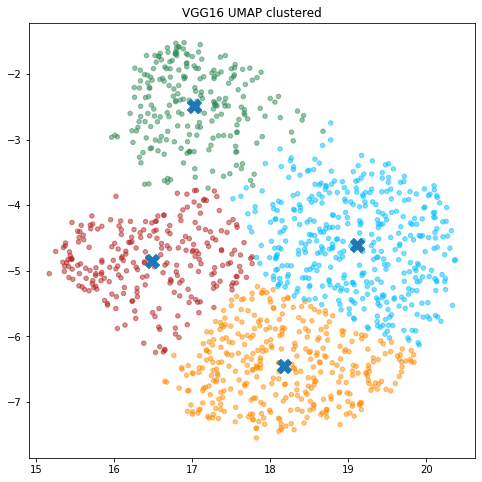

In [ ]:
# map label to colour
colours = {} 
colours[0] = 'darkorange'
colours[1] = 'deepskyblue'
colours[2] = 'seagreen'
colours[3] = 'firebrick'
colours[4] = 'm'
colours[5] = 'pink'
colours[-1] = 'gray'
  
# build the colour vector for each data point 
cvec = [colours[label] for label in labels] 
  
# plot the clustered scatter plot as above
fig, ax = plt.subplots(1,1, figsize=(8, 8)) 
ax.scatter(x, y, marker='o', c=cvec, alpha=0.5, s=20) 
# plot centroids
ax.scatter(centroids[:,0], centroids[:,1], marker='X', s=200)
# plot images
#annotation_boxes = images_in_plot(filter_file_list, x, y, num_2plot=90)
#for ab in annotation_boxes:
#  ax.add_artist(ab)
ax.set_title('VGG16 UMAP clustered')
mpl.rcParams['pdf.fonttype'] = 42
plt.savefig("VGG16_UMAP_clusterd.pdf", format='pdf', dpi=100, bbox_inches='tight')
plt.show(); plt.close()

In [ ]:
centroids

array([[ 16.820234, -11.63682 ],
       [ 15.094181, -12.839651],
       [ 15.551075, -15.344549],
       [ 17.38853 , -14.404589]], dtype=float32)

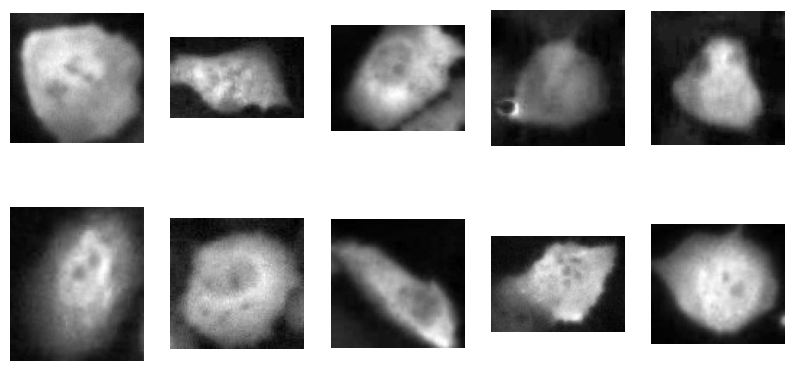

In [ ]:
# plot 10 ROIs closest to centroids
cluster_num = 0
cluster_1 = {}
for i in range(len(extracted_cluster)):
  if labels[i]==cluster_num:
    dist = np.linalg.norm(extracted_cluster[i] - centroids[0]) 
    cluster_1[i] = dist # add items to dict{index: dist}
 
 # sort by dist descending   
top_cluster_1 = sorted(cluster_1.items(), key=lambda item: item[1], reverse=True)

# get images
c1_im_list = []
for idx, dist in top_cluster_1[:20]: # grab 20 cells around the centroid
  c1_im_list.append(fltrd_file_list[idx])
random.shuffle(c1_im_list) # randomly sample a few of those cells to plot

# show images
fig, axes = plt.subplots(2,5, figsize=(10,5), dpi=100)
for ax, im_path in zip(axes.ravel(), c1_im_list):
  img = cv2.imread(im_path, -1)
  r = img[:,:,2]
  ax.imshow(r, cmap='gray')
  ax.set_axis_off()

plt.show()